In [18]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
import matplotlib.pyplot as plt

In [19]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [20]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)

In [21]:
np.shape(data_list)

(29, 100, 11)

In [22]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [23]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data_list, labels, target_samples=1000, noise_factor=5)

In [24]:
augmented_data = augmented_data.reshape(augmented_data.shape[0], -1)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

In [26]:
# Initialize the individual classifiers
xgb_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8
)

gb_classifier = GradientBoostingClassifier()

xgb_classifier.fit(X_train, y_train)
gb_classifier.fit(X_train, y_train)

# Combine the classifiers using a voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('xgb', xgb_classifier),
        ('gb', gb_classifier)
    ],
    voting='soft'
)

In [27]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

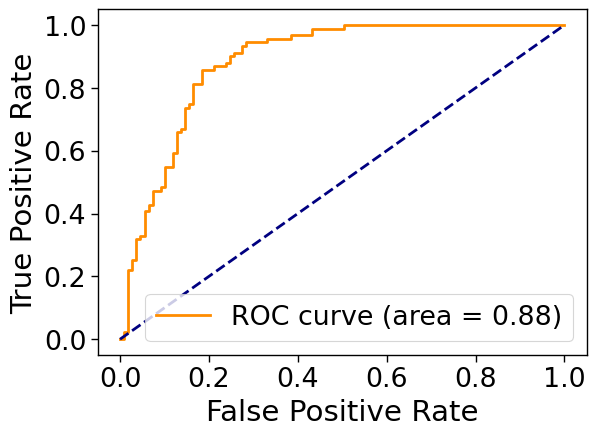

In [28]:
from sklearn.metrics import roc_curve, auc

y_prob = voting_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('roc_XGB_GB.eps', format='eps')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = voting_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
 [[81 28]
 [ 9 82]]
Accuracy: 0.815
Precision: 0.7454545454545455
Recall: 0.9010989010989011
F1-score: 0.8159203980099503


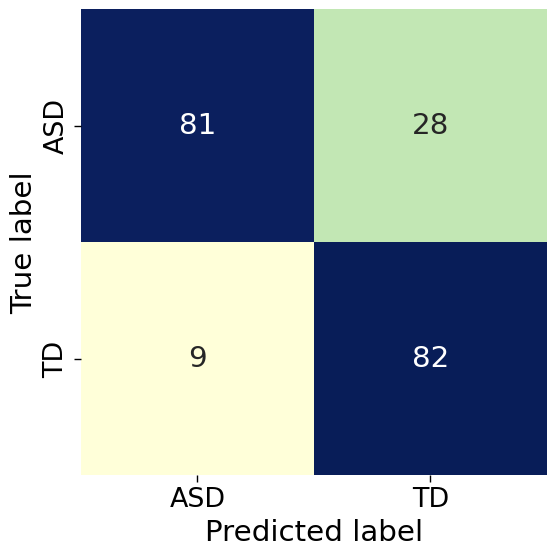

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
# sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_XGB_GB.eps', format='eps')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error

y_pred_regression = voting_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.185


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

""" Time domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, :6]
subset1_reshaped = subset1.reshape(1000, 600)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

voting_classifier.fit(X_train, y_train)


y_pred = voting_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = voting_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[82 27]
 [ 5 86]]
Accuracy: 0.84
Precision: 0.7610619469026548
Recall: 0.945054945054945
F1-score: 0.8431372549019607
Mean Squared Error: 0.16


In [33]:
""" Frequency domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, 6:11]
subset1_reshaped = subset1.reshape(1000, 500)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

voting_classifier.fit(X_train, y_train)


y_pred = voting_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = voting_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[70 39]
 [50 41]]
Accuracy: 0.555
Precision: 0.5125
Recall: 0.45054945054945056
F1-score: 0.4795321637426901
Mean Squared Error: 0.445
